In [2]:
# import os
ROOT = "/content/drive/MyDrive/FSDS/DL/project"
# os.chdir(ROOT)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pwd

'/content'

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms,datasets
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import pandas as pd

##Download Data

In [7]:
train_data = datasets.FashionMNIST(
    root= config.ROOT_DATA_DIR,
    train=True,
    download= True,
    transform=transforms.ToTensor()
    )

test_data = datasets.FashionMNIST(
    root=config.ROOT_DATA_DIR,
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting FashionMNISTDir/FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNISTDir/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting FashionMNISTDir/FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNISTDir/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting FashionMNISTDir/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNISTDir/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting FashionMNISTDir/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNISTDir/FashionMNIST/raw



In [6]:
class config:
    def __init__(self):
        self.ROOT_DATA_DIR = "Img_data_dir"
        self.EPOCH = 10
        self.BATCH_SIZE = 32
        self.LEARNING_RATE = 0.01
        # self.IMAGE_SIZE  = (28X28)
        self.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"this notebook is using: {self.DEVICE}")
        self.SEED = 205 
config = config()

this notebook is using: cuda


In [8]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [9]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [10]:
train_data.class_to_idx # Feature coloumn

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [11]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [12]:
given_label_map = train_data.class_to_idx
given_label_map

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [13]:
label_map = {key : val for key , val in given_label_map.items()}
label_map

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [14]:
label_map = {val : key for key , val in given_label_map.items()}
label_map

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

## Visualize 

(-0.5, 27.5, 27.5, -0.5)

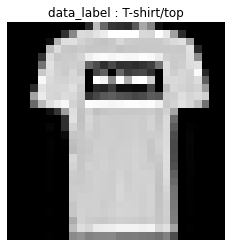

In [15]:
idx= 1
plt.imshow(train_data.data[idx],cmap="gray")
plt.title(f"data_label : {label_map[train_data.targets[idx].item()]}")
plt.axis('off')

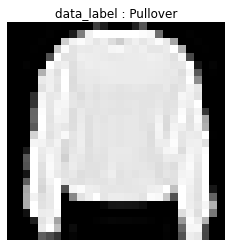

In [16]:
def view_sample_image(data,idx,label_map):
    # idx= 1
    plt.imshow(data.data[idx],cmap="gray")
    plt.title(f"data_label : {label_map[train_data.targets[idx].item()]}")
    plt.axis('off')

view_sample_image(train_data , idx=7 , label_map=label_map)

## Create Dataloder

In [17]:
train_data_loader = DataLoader(
                               dataset= train_data,
                               batch_size = config.BATCH_SIZE,
                               shuffle=True
                                )

In [18]:
test_data_loader = DataLoader(
                               dataset= test_data,
                               batch_size = config.BATCH_SIZE,
                               shuffle=False
                                )

In [19]:
for images,label in test_data_loader:
    print(images.shape)
    print(label.shape)
    break
################---32 is batch_size , for one image channel ,of 28 X28-------#########

torch.Size([32, 1, 28, 28])
torch.Size([32])


In [20]:
images[0].shape

torch.Size([1, 28, 28])

In [21]:
images[0].squeeze().shape

torch.Size([28, 28])

In [22]:
# plt.imshow(images[0].permute(1,2,0))--------not work

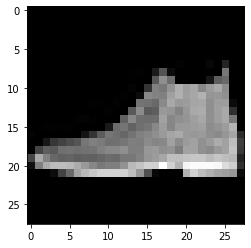

In [23]:
plt.imshow(images[0].squeeze(),cmap="gray")

In [24]:
images[0].shape , images[0].squeeze().shape , images[0].unsqueeze(dim=1).shape

(torch.Size([1, 28, 28]), torch.Size([28, 28]), torch.Size([1, 1, 28, 28]))

In [25]:
class CNN(nn.Module):
  def __init__(self, in_, out_):
    super(CNN, self).__init__()

    self.conv_pool_01 = nn.Sequential(
        nn.Conv2d(in_channels=in_, out_channels=8, kernel_size=5, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv_pool_02 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.Flatten = nn.Flatten()
    self.FC_01 = nn.Linear(in_features=16*4*4, out_features=128)
    self.FC_02 = nn.Linear(in_features=128, out_features=64)
    self.FC_03 = nn.Linear(in_features=64, out_features=out_)

  def forward(self, x):
    x = self.conv_pool_01(x)
    x = self.conv_pool_02(x)
    x = self.Flatten(x)
    x = self.FC_01(x)
    x = F.relu(x)
    x = self.FC_02(x)
    x = F.relu(x)    
    x = self.FC_03(x)
    return x

In [26]:
model = CNN(1,10)
print(model)

CNN(
  (conv_pool_01): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool_02): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (FC_01): Linear(in_features=256, out_features=128, bias=True)
  (FC_02): Linear(in_features=128, out_features=64, bias=True)
  (FC_03): Linear(in_features=64, out_features=10, bias=True)
)


In [27]:
model.conv_pool_02

Sequential(
  (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [28]:
model.Flatten

Flatten(start_dim=1, end_dim=-1)

In [29]:
#check its working on cuda or not

next(model.parameters()).is_cuda

False

In [30]:
model.to(config.DEVICE)

CNN(
  (conv_pool_01): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool_02): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (FC_01): Linear(in_features=256, out_features=128, bias=True)
  (FC_02): Linear(in_features=128, out_features=64, bias=True)
  (FC_03): Linear(in_features=64, out_features=10, bias=True)
)

In [31]:
next(model.parameters()).is_cuda

True

##Count the no. of trainable parameters


In [32]:
def count_params(model):
  model_params = {"Modules": list(), "Parameters": list()}
  total = {"trainable": 0, "non_trainable": 0} 
  for name, parameters in model.named_parameters():
    param = parameters.numel()
    if not parameters.requires_grad:
      total["non_trainable"] += param
      continue
    model_params["Modules"].append(name)
    model_params["Parameters"].append(param)
    total["trainable"] += param
  df = pd.DataFrame(model_params)
  df = df.style.set_caption(f"Total parameters: {total}")
  return df

count_params(model)

,Modules,Parameters
0,conv_pool_01.0.weight,200
1,conv_pool_01.0.bias,8
2,conv_pool_02.0.weight,3200
3,conv_pool_02.0.bias,16
4,FC_01.weight,32768
5,FC_01.bias,128
6,FC_02.weight,8192
7,FC_02.bias,64
8,FC_03.weight,640
9,FC_03.bias,10


## Training Loop

In [33]:
60000/32

1875.0

In [34]:
criterion = nn.CrossEntropyLoss() ## define the pre define loss function 
optimizer = torch.optim.Adam(model.parameters(),lr=config.LEARNING_RATE)

In [35]:
len(train_data_loader) #Step Per Epoch

1875

In [36]:
from torch.autograd import backward
for epoch in range(config.EPOCH):
  with tqdm(train_data_loader) as tqdm_epoch:
    for images,label in tqdm_epoch:
      tqdm_epoch.set_description(f"Epoch {epoch +1}/{config.EPOCH}")

      #put the images on device
      images = images.to(config.DEVICE)
      label = label.to(config.DEVICE)

      #Forward pass
      outputs =model(images)
      loss = criterion(outputs,label)  #passing the pred and targets

       #Backward Pass 
      optimizer.zero_grad() # reset the weight/gradient to zero or past gradient
      loss.backward() #calculate the gradient
      optimizer.step() # weight update

      tqdm_epoch.set_postfix(loss=loss.item())



Epoch 10/10: 100%|██████████| 1875/1875 [00:23<00:00, 78.30it/s, loss=0.204]


## save the model

In [37]:
os.makedirs('model_dir', exist_ok=True)
model_file = os.path.join('model_dir','CNN_model.pth')
torch.save(model,model_file)

##Load the model

In [38]:
loaded_model = torch.load(model_file)

##Evaluting

In [39]:
pred = np.array([])
target = np.array([])

with torch.no_grad():  #Now no gradient are update for prediction, all gradient are frozen
  for batch,data in enumerate(test_data_loader): # enmurate doing first show index/sequence value and second the data
    images = data[0].to(config.DEVICE)  
    label = data[1].to(config.DEVICE) 

    y_pred = model(images)


    
    pred = np.concatenate((pred , torch.argmax(y_pred,1).cpu().numpy()))
    target = np.concatenate((target,label.cpu().numpy()))

In [40]:
cm = confusion_matrix(target,pred)
cm

array([[771,   3,   8,  22,   5,   2, 185,   0,   4,   0],
       [  1, 966,   0,  22,   1,   1,   8,   0,   1,   0],
       [  4,   1, 638,   7, 185,   1, 161,   1,   2,   0],
       [ 31,  10,   7, 863,  33,   1,  52,   0,   3,   0],
       [  1,   2,  48,  30, 847,   2,  67,   0,   3,   0],
       [  0,   0,   0,   0,   0, 984,   0,  12,   0,   4],
       [124,   3,  52,  20, 125,   1, 657,   0,  18,   0],
       [  0,   0,   0,   0,   0,  24,   0, 959,   1,  16],
       [  0,   0,   1,   1,   3,   9,  16,   2, 968,   0],
       [  0,   0,   0,   0,   0,  16,   0,  46,   0, 938]])

In [41]:
label_map

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [42]:
label_map.values()

dict_values(['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

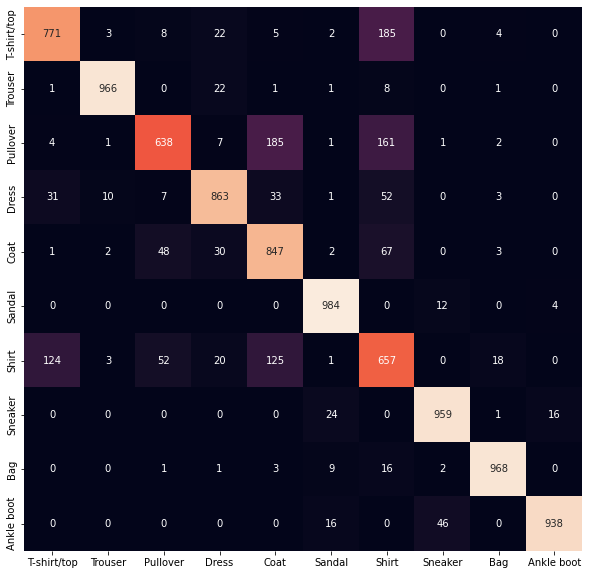

In [43]:
plt.figure(figsize=(10,10))
sns.heatmap(cm , annot=True , fmt='d', xticklabels=label_map.values() , yticklabels= label_map.values(), cbar=False)

##Prediction 

In [44]:
data = next(iter(test_data_loader))
data

[tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000

In [45]:
len(data)   

2

In [46]:
images , labels = data

In [47]:
images.shape

torch.Size([32, 1, 28, 28])

In [48]:
img = images[0]

In [49]:
img

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

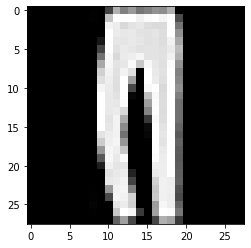

In [50]:
idx = 2
img = images[idx]
img.shape
plt.imshow(img.squeeze(),cmap='gray')

In [51]:
label = labels[idx]
label_map[label.item()]

'Trouser'

In [52]:
img.unsqueeze(dim=1)

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0039, 0.0000, 0.2627, 0.6941, 0.5059, 0.6000, 0.4588, 0.5059,
           0.5725, 0.5529, 0.6863, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0078, 0.0000, 0.7686, 1.0000, 1.0000, 1.0000, 0.9451, 0.9843,
           1.0000, 0.9608, 1.0000, 0.2980, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.9529, 0.9294, 0.8510, 0.8941, 0.9059, 0.8706,
           0.8549, 0.8588, 1.0000, 0.4549, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 1.0000, 0.9216, 0.9059, 0.9137, 0.8863, 0.8824,
           0.8980, 0.8706, 1.0000, 0.5686, 

In [53]:
logit = model(img.unsqueeze(dim=1).to(config.DEVICE))
logit

tensor([[ -23.3776,  113.0231,  -15.7307,   40.6950,  -17.2239, -357.6487,
          -50.5526, -468.0571,  -49.0487, -142.3990]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [54]:
sum([ -14.3534,   49.1092,  -36.7679,  -17.8715,  -12.7155,  -76.0015,
          -14.5143, -342.7687,  -38.3124,  -64.2676])         #Is not equal to 1

-568.4636

In [58]:
pred_prob = F.softmax(logit,dim=1)
pred_prob

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 3.8755e-32, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [61]:
sum([0.0000e+00, 1.0000e+00, 0.0000e+00, 3.8755e-32, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])  # Near to one

1.0

In [60]:
argmax = torch.argmax(pred_prob).item()
argmax

1

In [62]:
label_map[argmax]

'Trouser'

##Predicting Function

In [67]:
def predict(data,model,label_map,device,idx=0):
  images,labels = data

  img = images[idx]
  label = labels[idx]

  plt.imshow(img.squeeze(),cmap='gray')
  logit = model(img.unsqueeze(dim=1).to(config.DEVICE))
  pred_prob = F.softmax(logit,dim=1)
  argmax = torch.argmax(pred_prob).item()

  predicted_label = label_map[argmax]
  actual_label = label_map[label.item()]

  plt.title(f'actual : {actual_label} | predicted : {predicted_label}')
  return actual_label , predicted_label

('Pullover', 'Pullover')

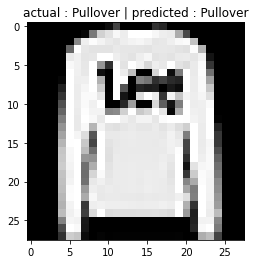

In [72]:
predict(data,model,label_map,config.DEVICE,idx=1)